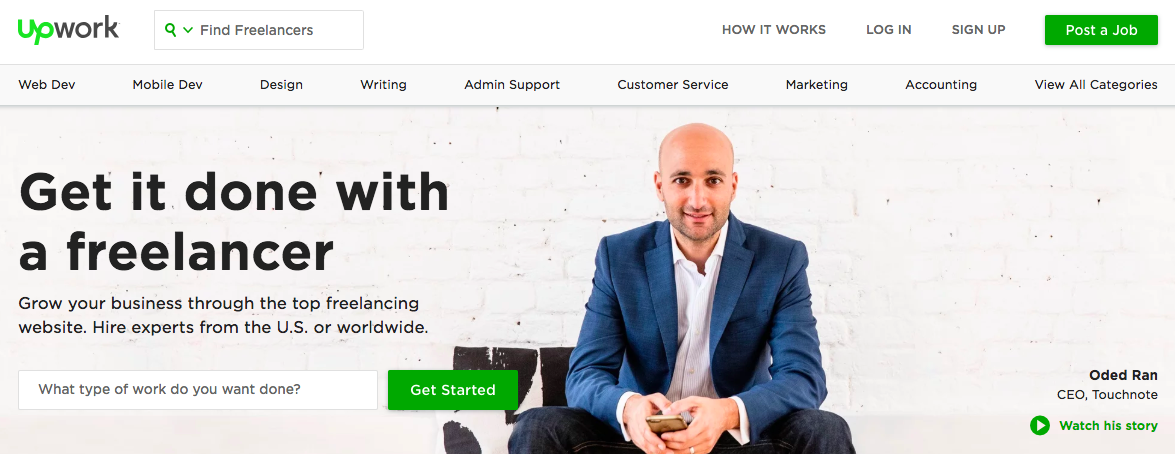

## Use case 1: Classify whether freelancers have done actual work (as a way to predict those who haven't yet but will)

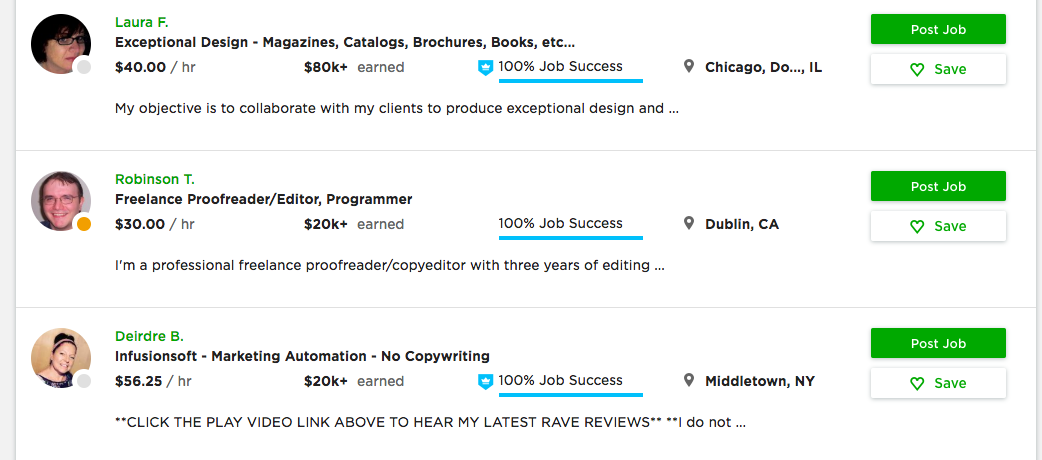

numeric features: 
* number of skills
* hourly rate
* number of educational degrees listed
* number of tests taken
* number of employers listed

text-based:
* length of headline (characters)
* average word length in headline
* length of bio (characters
* average word length in bio

categorical feature:
* skills
* skills cluster

### Importing data from file and cleaning it: webscraping with Selenium

In [158]:
import copy
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_curve, auc, log_loss
from keras.models import Sequential
from keras import initializers
from keras.layers import Dense, Dropout
from keras import optimizers
from kmodes.kmodes import KModes
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('./data/*')], ignore_index = True)

In [3]:
df.shape

(4950, 11)

In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.head()

,bio,earned,edu,exp,headline,hours,jobs,rate,skills,tests
0,Google Adwords & Bing Ads Certified MBA market...,$200k+,3.0,8.0,"Marketing, Strategic Mgmt/Writer/SEO, SEM/Mark...","10,654",40,$45.00,"['Strategic Planning', 'Business Analysis', 'A...",9.0
1,I have been transcribing for more than 7 years...,$10k+,2.0,1.0,Transcriptionist,"1,043",60,$12.00,"['Transcription', 'Medical Transcription']",2.0
2,"Throughout my undergraduate years, I was a res...",$60k+,1.0,3.0,"Transcription (98WPM), Virtual Assistant","2,840",254,$15.00,"['Biology', 'English', 'Transcription', 'Virtu...",4.0
3,As a digital marketing professional with a foc...,$30k+,2.0,2.0,Full-Stack Digital Marketer | Facebook Ads Spe...,673,21,$75.00,"['Facebook Marketing', 'Inbound Marketing', 'M...",4.0
4,WordPress Development + Theme Customization + ...,$40k+,NaN,1.0,Turn-Key Responsive Website Design & Development,625,131,$45.00,"['WordPress', 'Woocommerce', 'Website Developm...",1.0


In [6]:
df = df.drop_duplicates()

In [7]:
df.shape

(4262, 10)

In [8]:
df.dtypes

bio          object
earned       object
edu         float64
exp         float64
headline     object
hours        object
jobs         object
rate         object
skills       object
tests       float64
dtype: object

In [9]:
df.isna().sum()

bio           17
earned      1525
edu          256
exp          796
headline      24
hours       1523
jobs        1494
rate           2
skills        70
tests       2017
dtype: int64

In [10]:
df = df[df.rate.notna()]

In [11]:
df.shape

(4260, 10)

In [12]:
df['skills'] = df['skills'].fillna('[]')

In [13]:
df['headline'] = df['headline'].fillna('')

In [14]:
df['bio'] = df['bio'].fillna('')

In [15]:
# sometimes hours and jobs will be zero but earned will be a positive number.
# the below will allow one to check the earned column to see whether a freelancer has worked or not
df = df.fillna('0')

In [16]:
df['rate'] = df['rate'].map(lambda string: float(''.join([c for c in string if c.isdigit()]))/100)

In [17]:
df['hours'] = df['hours'].map(lambda h: int(''.join([c for c in str(h) if c.isdigit()])))

In [18]:
df['jobs'] = df['jobs'].map(lambda j: int(''.join([c for c in str(j) if c.isdigit()])))

In [19]:
df['exp'] = df['exp'].map(lambda e: int(e))

In [20]:
df['edu'] = df['edu'].map(lambda e: int(e))

In [21]:
df['tests'] = df['tests'].map(lambda t: int(t))

In [22]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.replace('[', ""))

In [23]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.replace(']', ""))

In [24]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.replace("'", ""))

In [25]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.replace('"', ''))

In [26]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.split(", "))

In [27]:
# ternary operator
df['skills'] = df['skills'].map(lambda sk_list: (sk_list, [])[sk_list == ['']])

In [28]:
df.dtypes

bio          object
earned       object
edu           int64
exp           int64
headline     object
hours         int64
jobs          int64
rate        float64
skills       object
tests         int64
dtype: object

In [29]:
len(df)

4260

In [30]:
nn = 0
for i in range(len(df)):
    nn += (type(df['skills'].iloc[55]) == list)
nn

4260

In [31]:
df = df.reset_index(drop = True)

In [32]:
# df = df[df.rate < 200]

In [33]:
y = (df['earned'] != '0')

In [34]:
sum(y)

2735

### Each freelancer can choose up to 10 out of 1500+ skills to list.  To avoid the curse of dimensionality, we use k-modes clustering (analagous to k-means but for categorical data)

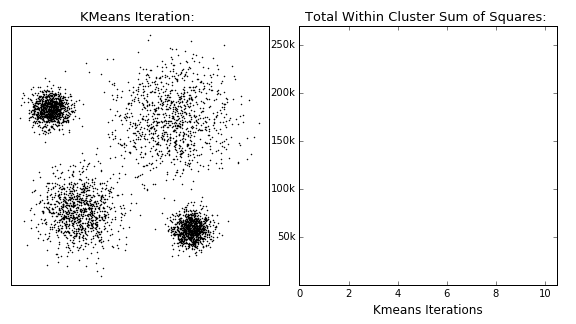

In [35]:
skills_df = df['skills'].str.join('|').str.get_dummies()

In [36]:
skills_df.shape

(4260, 2309)

In [37]:
km = KModes(n_clusters=13, init='Huang', n_init=11, verbose=1)
clusters = km.fit_predict(skills_df)
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 323, cost: 30048.0
Run 1, iteration: 2/100, moves: 30, cost: 30048.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 399, cost: 29725.0
Run 2, iteration: 2/100, moves: 20, cost: 29725.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1, cost: 30283.0
Run 3, iteration: 2/100, moves: 10, cost: 30264.0
Run 3, iteration: 3/100, moves: 43, cost: 30213.0
Run 3, iteration: 4/100, moves: 12, cost: 30213.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 334, cost: 29526.0
Run 4, iteration: 2/100, moves: 56, cost: 29526.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 311, cost: 30287.0
Run 5, iteration: 2/100, moves: 190, cost: 3013

In [38]:
kmodes = km.cluster_centroids_
shape = kmodes.shape

In [39]:
for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in skills_df.columns[np.nonzero(cent)]:
            print(j)


cluster 0: 
Social Media Marketing

cluster 1: 
Microsoft Excel

cluster 2: 
no-skills cluster

cluster 3: 
Blog Writing
Content Writing

cluster 4: 
Accounting
Bookkeeping
Intuit QuickBooks

cluster 5: 
Translation English Spanish
Translation Spanish English

cluster 6: 
Software QA Testing

cluster 7: 
Adobe Illustrator
Adobe InDesign
Adobe Photoshop

cluster 8: 
CSS
HTML
JavaScript

cluster 9: 
CSS3
HTML5
JavaScript

cluster 10: 
English

cluster 11: 
Microsoft Office

cluster 12: 
Data Entry


In [40]:
clust_assigned = km.predict(skills_df)

In [41]:
unique, counts = np.unique(clust_assigned, return_counts=True)
dict(zip(unique, counts))

{0: 295,
 1: 385,
 2: 2210,
 3: 100,
 4: 55,
 5: 27,
 6: 53,
 7: 223,
 8: 359,
 9: 211,
 10: 88,
 11: 119,
 12: 135}

### Making the predictor matrix (more feature engineering)

In [42]:
X = df.drop(['earned', 'hours', 'jobs'], axis = 1)

In [43]:
X.skills = X.skills.map(lambda li: len(li))

In [44]:
fn = lambda row: len(row.headline) # define a function for the new column
X = X.assign(head_len = X.apply(fn, axis=1).values)

In [45]:
fn = lambda row: len(row.headline.split(' ')) # define a function for the new column
X = X.assign(head_num_words = X.apply(fn, axis=1).values)

In [46]:
fn = lambda row: len(row.bio) # define a function for the new column
X = X.assign(bio_len = X.apply(fn, axis=1).values)

In [47]:
fn = lambda row: len(row.bio.split(' ')) # define a function for the new column
X = X.assign(bio_num_words = X.apply(fn, axis=1).values)

In [48]:
X.head()

,bio,edu,exp,headline,rate,skills,tests,head_len,head_num_words,bio_len,bio_num_words
0,Google Adwords & Bing Ads Certified MBA market...,3,8,"Marketing, Strategic Mgmt/Writer/SEO, SEM/Mark...",45.0,8,9,66,6,2608,381
1,I have been transcribing for more than 7 years...,2,1,Transcriptionist,12.0,2,2,16,1,305,50
2,"Throughout my undergraduate years, I was a res...",1,3,"Transcription (98WPM), Virtual Assistant",15.0,10,4,40,4,430,69
3,As a digital marketing professional with a foc...,2,2,Full-Stack Digital Marketer | Facebook Ads Spe...,75.0,5,4,53,7,2050,329
4,WordPress Development + Theme Customization + ...,0,1,Turn-Key Responsive Website Design & Development,45.0,6,1,48,6,664,85


In [49]:
X = X.drop(['bio', 'headline'], axis = 1)

In [50]:
# X = X.reset_index(drop = True)

In [51]:
clust = pd.Series(clust_assigned)

In [52]:
# clust = clust.reset_index(drop = True)

In [53]:
result = pd.concat([X, clust], axis = 1, sort = False)

In [54]:
result.rename(columns={0: 'cluster'}, inplace=True)

In [55]:
result_dum = pd.get_dummies(result, columns = ['cluster'])

In [56]:
result_dum.head()

,edu,exp,rate,skills,tests,head_len,head_num_words,bio_len,bio_num_words,cluster_0,...,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
0,3,8,45.0,8,9,66,6,2608,381,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,12.0,2,2,16,1,305,50,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,15.0,10,4,40,4,430,69,0,...,0,0,0,0,0,0,0,0,0,0
3,2,2,75.0,5,4,53,7,2050,329,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,45.0,6,1,48,6,664,85,0,...,0,0,0,0,0,0,1,0,0,0


### Exploratory Data Analysis (EDA)

In [57]:
Xr = pd.concat([result, y], axis = 1, sort = False)

In [58]:
yes = Xr[Xr['earned'] == True]
no = Xr[Xr['earned'] == False]
nn = len(no)
ny = len(yes)

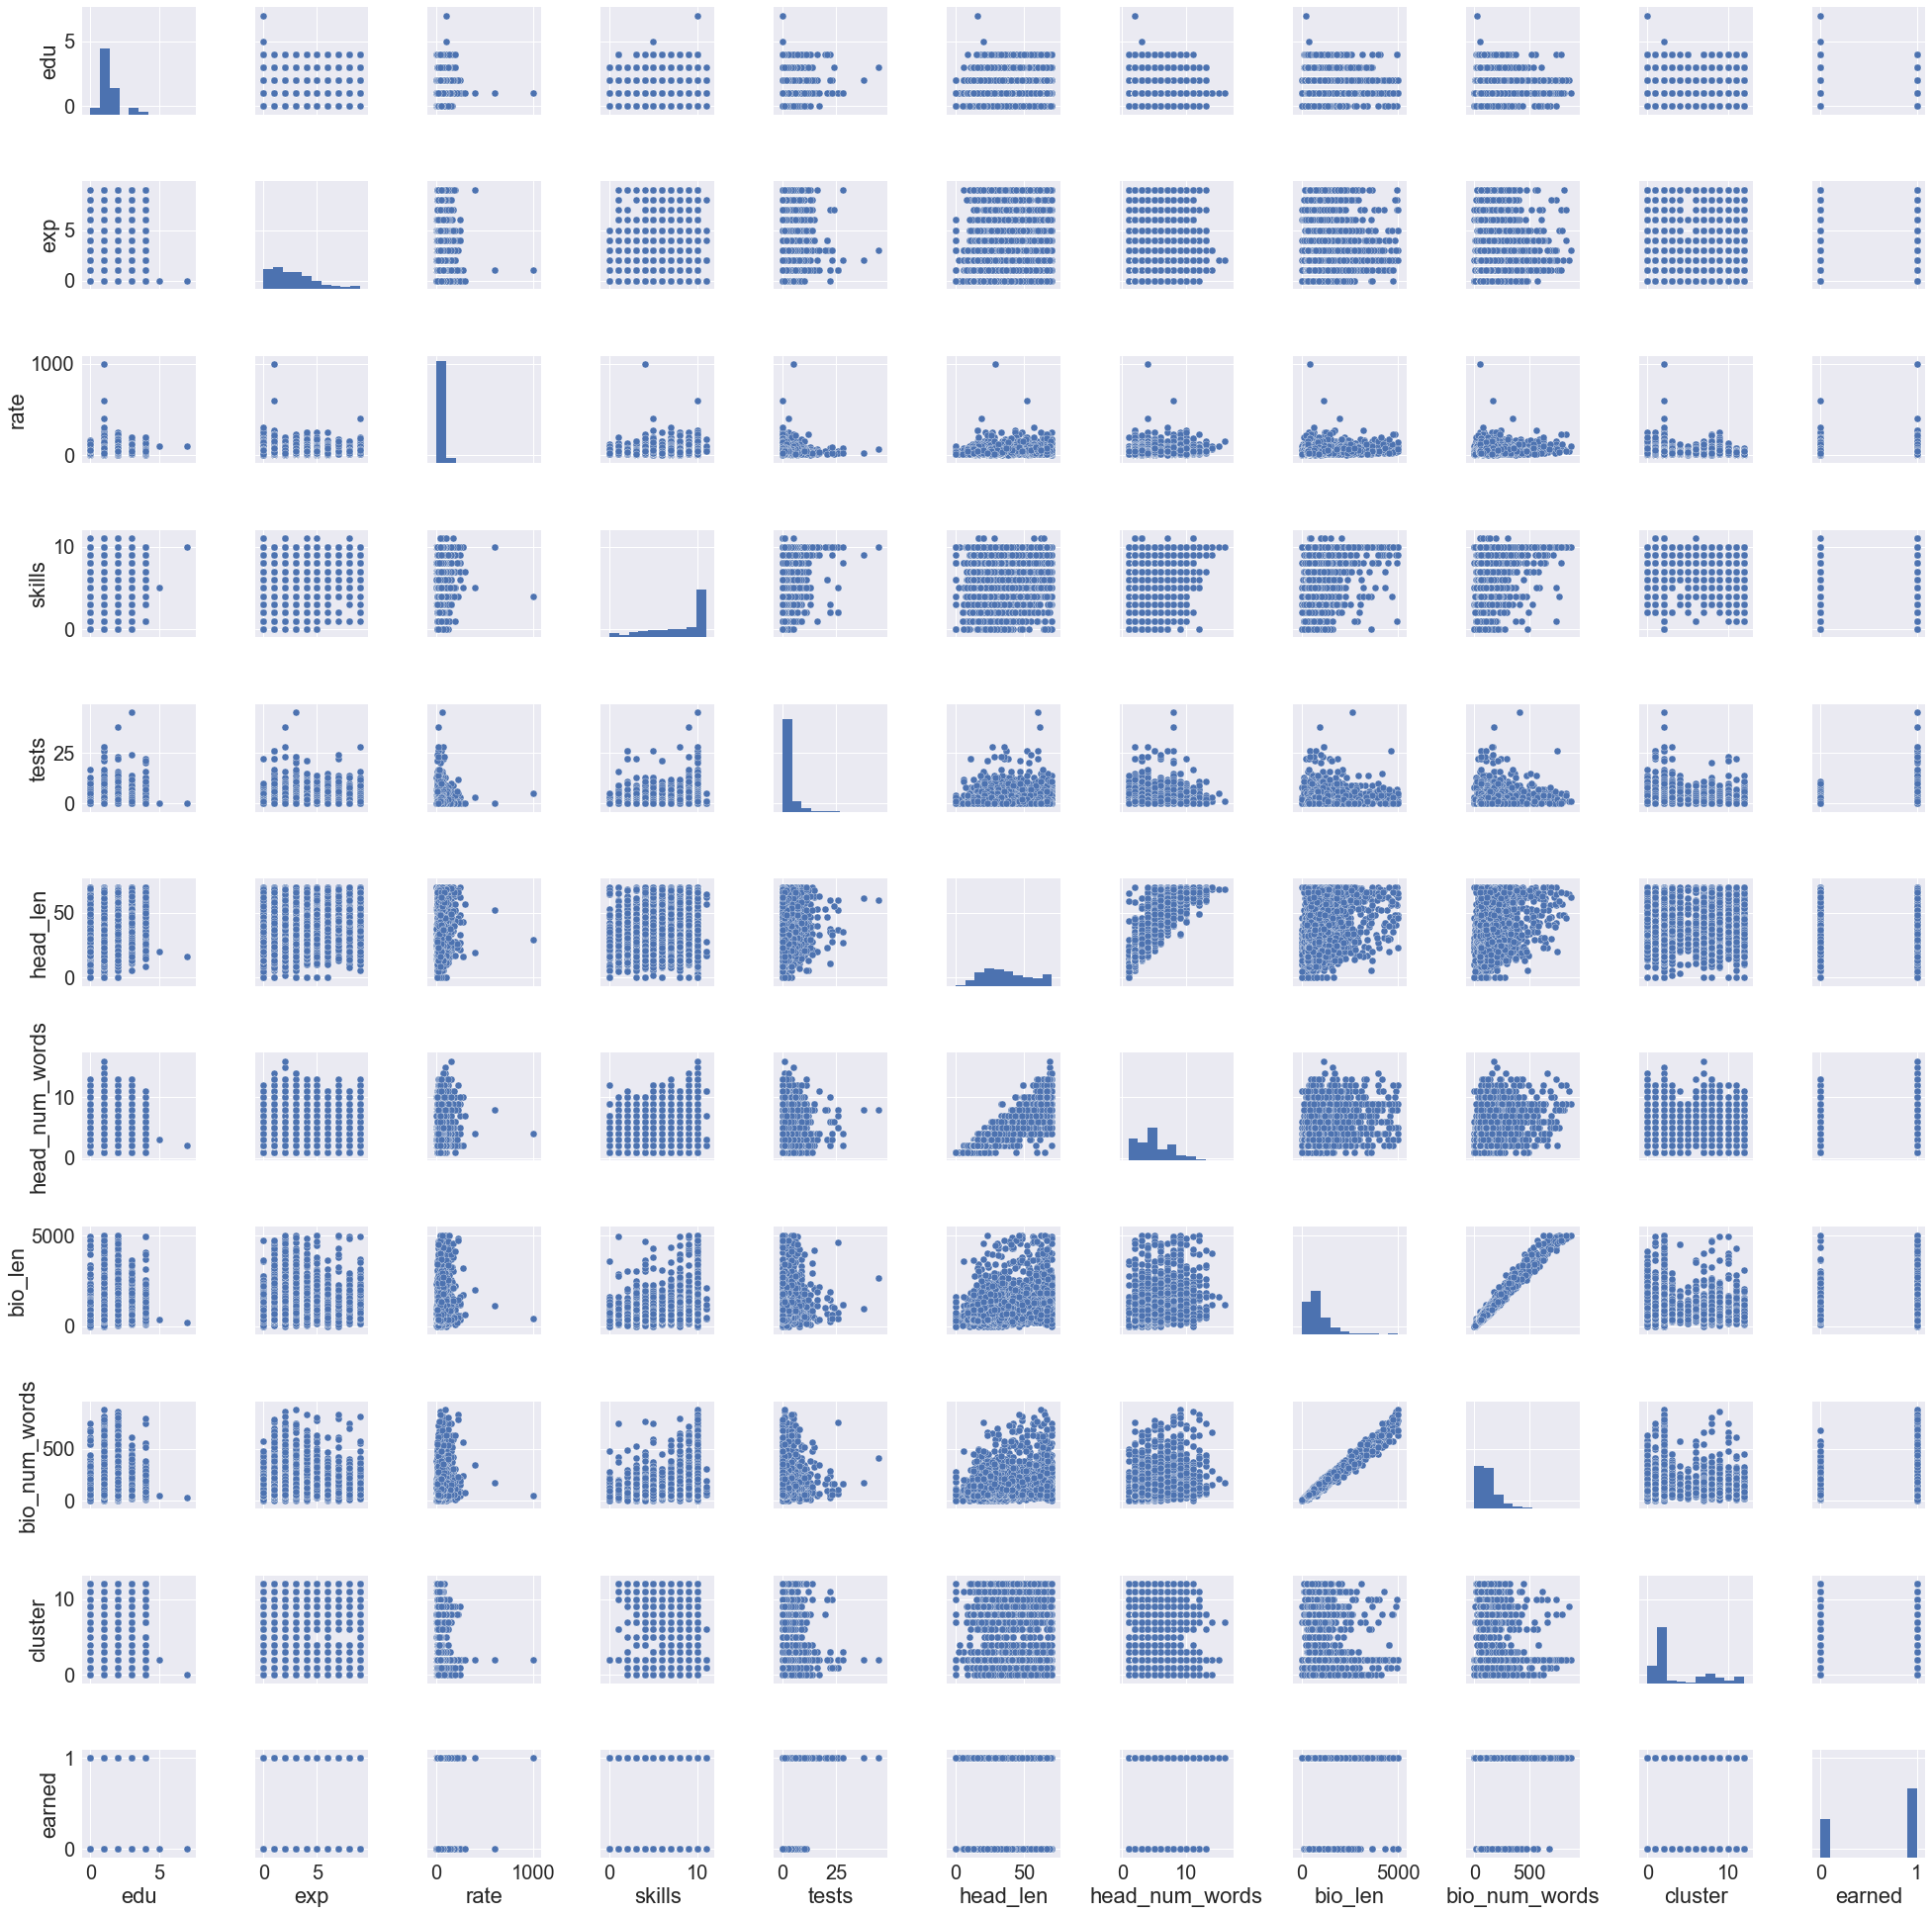

In [59]:
sns.set(font_scale = 2)
sns.pairplot(Xr)

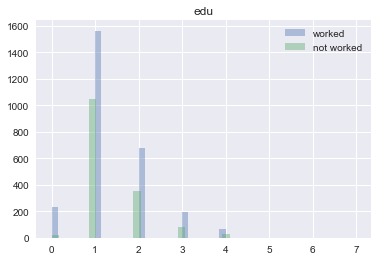

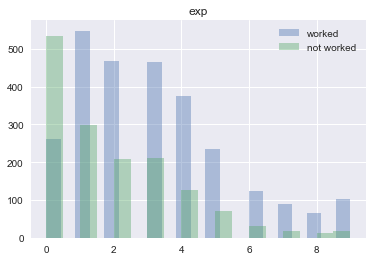

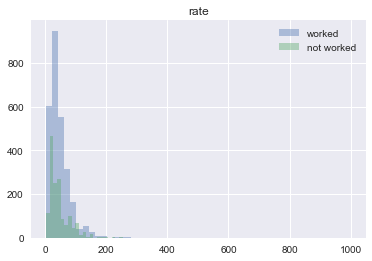

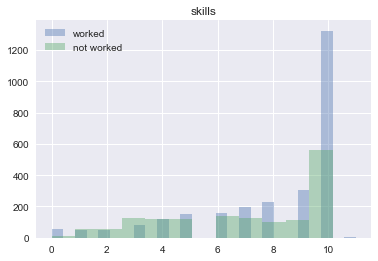

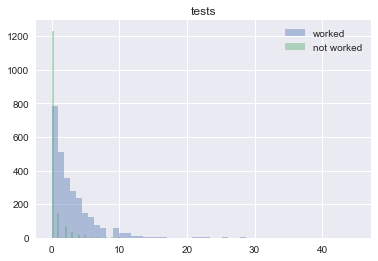

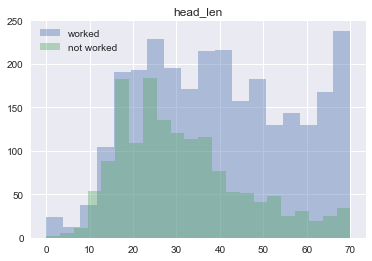

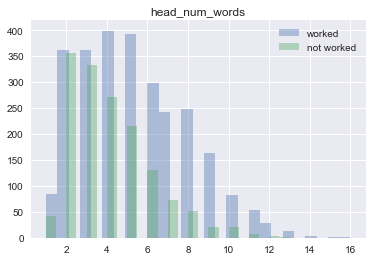

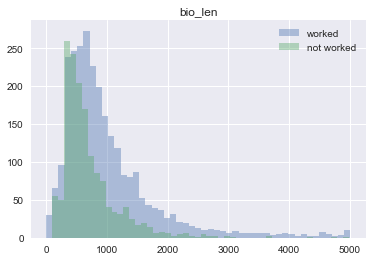

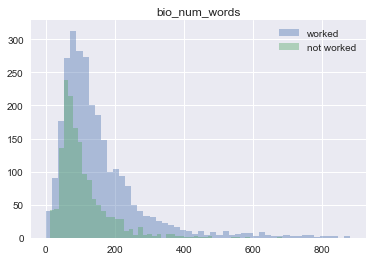

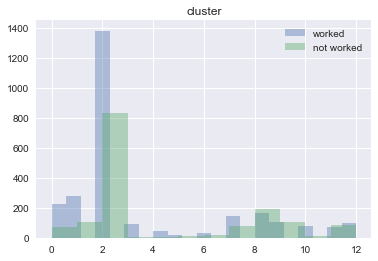

In [128]:
sns.set(font_scale = 1)
for name in Xr.columns[:-1]:
    a = yes[name].values
    b = no[name].values
    sns.distplot(a, label = 'worked', kde = False, rug = False)
    sns.distplot(b, label = 'not worked', kde = False, rug = False)
    plt.legend()
    plt.title(name)
    plt.show()

In [129]:
cd = []
for name in Xr.columns[:-1]:
    a = yes[name].values
    b = no[name].values
    cd.append((name,((np.mean(a) - np.mean(b)) / 
                                        np.sqrt(((ny - 1)*np.std(a)**2 + (nn - 1)*np.std(b)**2) / (nn + ny - 2)))))
print("Cohen's d: \n")
cd

Cohen's d: 



[('edu', 0.010777255714492943),
 ('exp', 0.5746191285112368),
 ('rate', 0.03670700053357379),
 ('skills', 0.33716677110198534),
 ('tests', 0.8005476594107513),
 ('head_len', 0.5227158881713535),
 ('head_num_words', 0.5051639133850829),
 ('bio_len', 0.4397329920045576),
 ('bio_num_words', 0.43339500935857894),
 ('cluster', -0.12418956760806342)]

### Normalizing the predictor variables

In [130]:
norm_x = scale(X)

In [131]:
pca = PCA()
nx = pca.fit_transform(norm_x)

In [132]:
pca.explained_variance_

array([2.85727816, 1.4117533 , 1.28164352, 0.9786181 , 0.86470191,
       0.79230857, 0.69090378, 0.11060621, 0.01429962])

In [133]:
nx = pd.DataFrame(nx)

In [134]:
nx.head()

,0,1,2,3,4,5,6,7,8
0,4.362674,0.452479,2.360764,-1.206578,-0.762454,1.019199,-0.422269,0.764307,0.043956
1,-2.660261,0.512092,0.655180,-0.992233,-1.171284,0.932842,0.245985,0.171830,-0.015952
2,-0.448239,-0.853932,0.557197,-0.456581,1.063842,-0.550507,0.176367,0.344609,-0.041316
3,2.354770,0.878633,-0.587753,-0.574823,-1.058020,1.234755,0.335314,0.057720,-0.121117
4,-0.513822,-0.629701,-1.858548,-0.407296,0.656814,0.096989,-0.445086,0.196543,0.102606


In [135]:
norm_result = pd.concat([nx, clust], axis = 1, sort = False)

In [136]:
norm_result.columns = result.columns

In [137]:
norm_result.head()

,edu,exp,rate,skills,tests,head_len,head_num_words,bio_len,bio_num_words,cluster
0,4.362674,0.452479,2.360764,-1.206578,-0.762454,1.019199,-0.422269,0.764307,0.043956,2
1,-2.660261,0.512092,0.655180,-0.992233,-1.171284,0.932842,0.245985,0.171830,-0.015952,2
2,-0.448239,-0.853932,0.557197,-0.456581,1.063842,-0.550507,0.176367,0.344609,-0.041316,1
3,2.354770,0.878633,-0.587753,-0.574823,-1.058020,1.234755,0.335314,0.057720,-0.121117,0
4,-0.513822,-0.629701,-1.858548,-0.407296,0.656814,0.096989,-0.445086,0.196543,0.102606,9


In [138]:
norm_dum = pd.get_dummies(norm_result, columns = ['cluster'])

In [139]:
norm_dum.head()

,edu,exp,rate,skills,tests,head_len,head_num_words,bio_len,bio_num_words,cluster_0,...,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
0,4.362674,0.452479,2.360764,-1.206578,-0.762454,1.019199,-0.422269,0.764307,0.043956,0,...,0,0,0,0,0,0,0,0,0,0
1,-2.660261,0.512092,0.655180,-0.992233,-1.171284,0.932842,0.245985,0.171830,-0.015952,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.448239,-0.853932,0.557197,-0.456581,1.063842,-0.550507,0.176367,0.344609,-0.041316,0,...,0,0,0,0,0,0,0,0,0,0
3,2.354770,0.878633,-0.587753,-0.574823,-1.058020,1.234755,0.335314,0.057720,-0.121117,1,...,0,0,0,0,0,0,0,0,0,0
4,-0.513822,-0.629701,-1.858548,-0.407296,0.656814,0.096989,-0.445086,0.196543,0.102606,0,...,0,0,0,0,0,0,1,0,0,0


### Running the models

In [72]:
cv = 4

In [73]:
tr = DecisionTreeClassifier(max_depth = 3)
trmodel = tr.fit(result_dum, y)

In [74]:
trmodel.score(result_dum, y)

0.7643192488262911

In [75]:
np.mean(cross_val_score(trmodel, result_dum, y, scoring = 'accuracy', cv = cv))

0.7638282705515208

In [76]:
np.mean(cross_val_score(trmodel, result_dum, y, scoring = 'roc_auc', cv = cv))

0.8146238300092841

In [77]:
ntr = DecisionTreeClassifier(max_depth = 3)
ntrmodel = ntr.fit(norm_dum, y)

In [78]:
ntrmodel.score(norm_dum, y)

0.72018779342723

In [79]:
np.mean(cross_val_score(ntrmodel, norm_dum, y, scoring = 'accuracy', cv = cv))

0.6952955476017952

In [80]:
np.mean(cross_val_score(ntrmodel, norm_dum, y, scoring = 'roc_auc', cv = cv))

0.727332336905623

In [81]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 5)
rfmodel = rf.fit(result_dum, y)

In [82]:
rfmodel.score(result_dum, y)

0.7969483568075117

In [83]:
np.mean(cross_val_score(rfmodel, result_dum, y, scoring = 'accuracy', cv = cv))

0.7828463316351816

In [84]:
np.mean(cross_val_score(rfmodel, result_dum, y, scoring = 'roc_auc', cv = cv))

0.8374774441923544

In [85]:
nrf = RandomForestClassifier(n_estimators = 500, max_depth = 5)
nrfmodel = nrf.fit(norm_dum, y)

In [86]:
nrfmodel.score(norm_dum, y)

0.7603286384976525

In [87]:
np.mean(cross_val_score(nrfmodel, norm_dum, y, scoring = 'accuracy', cv = cv))

0.7288665003251462

In [88]:
np.mean(cross_val_score(nrfmodel, norm_dum, y, scoring = 'roc_auc', cv = cv))

0.7863459239555204

[ 4  1  5  7  8  6  0  3  2 17 12 18  9 11 10 19 21 15 13 20 16 14]


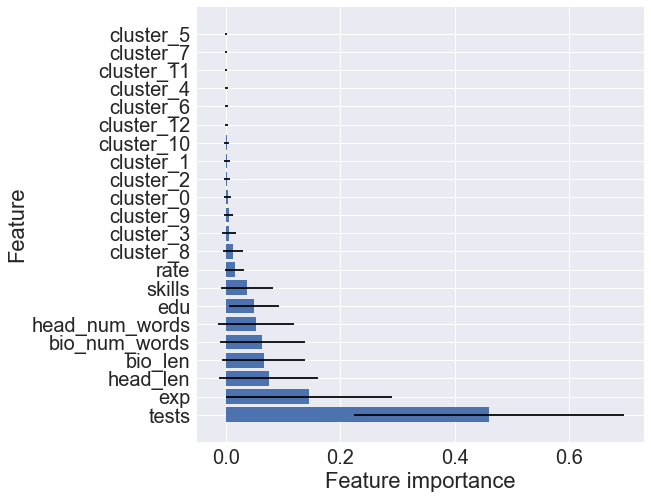

In [89]:
def plot_feature_importances(model):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print(indices)
    n_features = norm_dum.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), importances[indices], xerr=std[indices], align='center') 
    plt.yticks(np.arange(n_features), norm_dum.columns.values[indices]) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rfmodel)

In [90]:
lr = LogisticRegression()
lrmodel = lr.fit(result_dum, y)

In [91]:
lrmodel.score(result_dum, y)

0.7713615023474178

In [92]:
np.mean(cross_val_score(lrmodel, result_dum, y, scoring = 'accuracy', cv = 4))

0.7596167989968049

In [93]:
np.mean(cross_val_score(lrmodel, result_dum, y, scoring = 'roc_auc', cv = cv))

0.8204976418499724

In [94]:
nlr = LogisticRegression()
nlrmodel = nlr.fit(norm_dum, y)

In [95]:
nlrmodel.score(norm_dum, y)

0.7723004694835681

In [96]:
np.mean(cross_val_score(nlrmodel, norm_dum, y, scoring = 'accuracy', cv = 4))

0.7596165787887523

In [97]:
np.mean(cross_val_score(nlrmodel, norm_dum, y, scoring = 'roc_auc', cv = 4))

0.8205945580175429

In [147]:
svm = SVC(kernel = 'rbf', C = .62, probability = True)
svmmodel = svm.fit(result_dum, y)

In [148]:
svmmodel.score(result_dum, y)

0.7023474178403756

In [149]:
np.mean(cross_val_score(svmmodel, result_dum, y, scoring = 'accuracy', cv = 4))

0.6420188418453845

In [150]:
np.mean(cross_val_score(svmmodel, result_dum, y, scoring = 'roc_auc', cv = 4))

0.594361935389061

In [151]:
nsvm = SVC(kernel = 'rbf', probability = True)
nsvmmodel = nsvm.fit(norm_dum, y)

In [152]:
nsvmmodel.score(norm_dum, y)

0.7873239436619718

In [153]:
np.mean(cross_val_score(nsvmmodel, norm_dum, y, scoring = 'accuracy', cv = 4))

0.7685345657434287

In [154]:
np.mean(cross_val_score(nsvmmodel, norm_dum, y, scoring = 'roc_auc', cv = 4))

0.8256731442221554

In [106]:
nb = GaussianNB() 
nbmodel = nb.fit(result_dum, y)

In [107]:
nbmodel.score(result_dum, y)

0.6483568075117371

In [108]:
np.mean(cross_val_score(svmmodel, result_dum, y, scoring = 'accuracy', cv = 4))

0.6420188418453845

In [109]:
np.mean(cross_val_score(svmmodel, result_dum, y, scoring = 'roc_auc', cv = 4))

0.594361935389061

In [110]:
nnb = GaussianNB() 
nnbmodel = nnb.fit(norm_dum, y)

In [111]:
nnbmodel.score(norm_dum, y)

0.5901408450704225

In [112]:
np.mean(cross_val_score(nnbmodel, norm_dum, y, scoring = 'accuracy', cv = 4))

0.5833415182845203

In [113]:
np.mean(cross_val_score(nnbmodel, norm_dum, y, scoring = 'roc_auc', cv = 4))

0.7024150184544926

In [167]:
model = Sequential()
model.add(Dense(10, input_dim=22, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, input_dim=22, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(norm_dum, y, validation_split = 0.25, batch_size=10, 
                 epochs=100, verbose = True)

Train on 3195 samples, validate on 1065 samples
Epoch 1/100
3195/3195 [==============================] - 2s 543us/step - loss: 0.6680 - acc: 0.6485 - val_loss: 0.8113 - val_acc: 0.3437
Epoch 2/100
3195/3195 [==============================] - 1s 288us/step - loss: 0.5475 - acc: 0.7402 - val_loss: 0.8842 - val_acc: 0.3117
Epoch 3/100
3195/3195 [==============================] - 1s 283us/step - loss: 0.5218 - acc: 0.7502 - val_loss: 0.8865 - val_acc: 0.3117
Epoch 4/100
3195/3195 [==============================] - 1s 274us/step - loss: 0.5148 - acc: 0.7537 - val_loss: 0.8830 - val_acc: 0.3127
Epoch 5/100
3195/3195 [==============================] - 1s 282us/step - loss: 0.5036 - acc: 0.7590 - val_loss: 0.8622 - val_acc: 0.3192
Epoch 6/100
3195/3195 [==============================] - 1s 286us/step - loss: 0.4880 - acc: 0.7725 - val_loss: 0.8651 - val_acc: 0.3296
Epoch 7/100
3195/3195 [==============================] - 1s 291us/step - loss: 0.4836 - acc: 0.7703 - val_loss: 0.8496 - val_acc: 

3195/3195 [==============================] - 1s 338us/step - loss: 0.4427 - acc: 0.7956 - val_loss: 0.8360 - val_acc: 0.5183
Epoch 61/100
3195/3195 [==============================] - 1s 311us/step - loss: 0.4342 - acc: 0.8000 - val_loss: 0.8453 - val_acc: 0.5258
Epoch 62/100
3195/3195 [==============================] - 1s 304us/step - loss: 0.4342 - acc: 0.7981 - val_loss: 0.8775 - val_acc: 0.4883
Epoch 63/100
3195/3195 [==============================] - 1s 297us/step - loss: 0.4314 - acc: 0.8041 - val_loss: 0.8780 - val_acc: 0.4742
Epoch 64/100
3195/3195 [==============================] - 1s 328us/step - loss: 0.4287 - acc: 0.8025 - val_loss: 0.8475 - val_acc: 0.5164
Epoch 65/100
3195/3195 [==============================] - 1s 362us/step - loss: 0.4270 - acc: 0.7972 - val_loss: 0.8730 - val_acc: 0.4911
Epoch 66/100
3195/3195 [==============================] - 1s 348us/step - loss: 0.4308 - acc: 0.7922 - val_loss: 0.8698 - val_acc: 0.4864
Epoch 67/100
3195/3195 [=======================

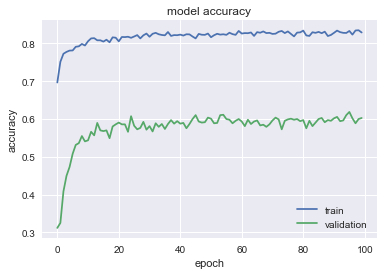

In [164]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [155]:
xtrain, xtest, ytrain, ytest = train_test_split(result_dum, y)

In [165]:
def plot_roc(model, name):
    probas = model.predict_proba(xtest)
    fpr, tpr, threshold = roc_curve(ytest, probas[:,1])  
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'AUC = %0.2f %s' % (roc_auc, name))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

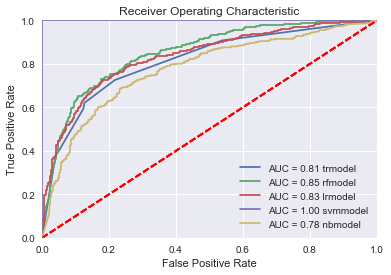

In [166]:
for md, nm in [(trmodel, 'trmodel'), (rfmodel, 'rfmodel'), (lrmodel, 'lrmodel'), (svmmodel, 'svmmodel'), (nbmodel, 'nbmodel')]:
    plot_roc(md, nm)
plt.show()